# Creating an OvR Model with Logistic Regression 

OvR Stands for One-vs-Rest. We'll define it later. In this notebook we are going to create a generalized Logistic Regression model by going through all the steps necessary. We are going to use the Iris dataset. It has 3 classes which is entirely suitable for this endeavor. You can download the dataset by running the following cell.


In [ ]:
!wget https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv

--2021-02-26 22:30:28--  https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3858 (3.8K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.77K  --.-KB/s    in 0s      

2021-02-26 22:30:28 (57.5 MB/s) - ‘iris.csv’ saved [3858/3858]



In [ ]:
import pandas as pd


#load the dataset, we need it for all the notebook


df_iris = pd.read_csv("/content/iris.csv")

#now, description of the Iris dataset

print(df_iris.shape)

df_iris.describe()

(150, 5)


,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


#One: The Importance of Visualizing Data

First, look at the following cell:

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7d2d9811d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d2d79b990>)

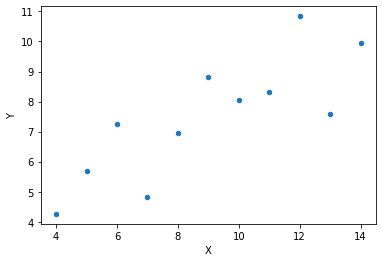

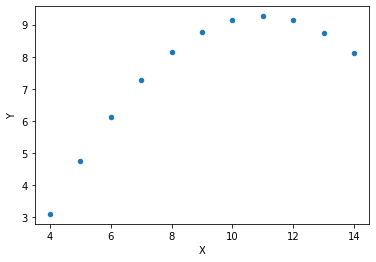

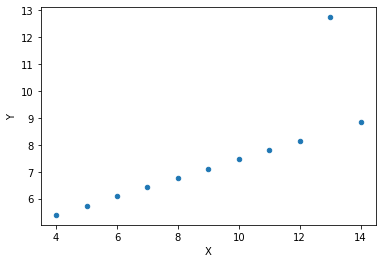

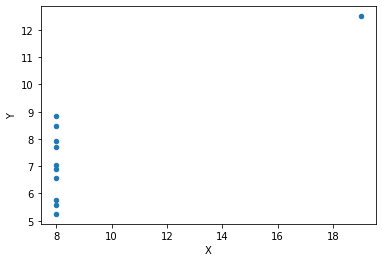

In [ ]:

df_anscombe = pd.read_json("/content/sample_data/anscombe.json")

df_anscombe_I = df_anscombe[df_anscombe["Series"] == "I"]
df_anscombe_II = df_anscombe[df_anscombe["Series"] == "II"]
df_anscombe_III = df_anscombe[df_anscombe["Series"] == "III"]
df_anscombe_IV = df_anscombe[df_anscombe["Series"] == "IV"]

df_anscombe_I.plot.scatter(x="X", y="Y"),\
                 df_anscombe_II.plot.scatter(x="X", y="Y"),\
                 df_anscombe_III.plot.scatter(x="X", y="Y"), \
                 df_anscombe_IV.plot.scatter(x="X", y="Y")

As you can clearly see, these plots are all different. What if I told you the mean, variance, correlation, and the best-fit line of all these plots is THE SAME? This dataset is called [
As you can clearly see, these plots are all different. What if I told you the mean, variance, correlation, and the best-fit line of all these plots is THE SAME? This dataset is called [Anscombe's Quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet) and the main thing that we can take away from it is, we should ALWAYS visualize data. Scatterplot for numerical data, and histogram or barplot for categorical data. 

So we did get all the *descriptive stats* of the Iris dataset in the cell we loaded it, however, we really need to visualize it. 

Can you do that? Collapse the following cell to see the answer.

# One Solution: Visualizing Iris Data

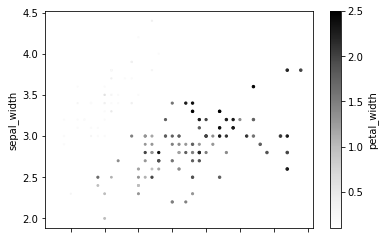

In [ ]:
#scatter

df_iris.plot.scatter(x="sepal_length", y="sepal_width", s="petal_length", c="petal_width")


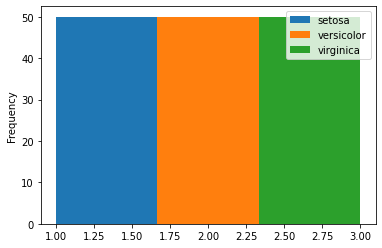

In [ ]:
#histogram

import matplotlib.pyplot as plt

df_iris_dummies = pd.get_dummies(df_iris.loc[:, "species"])

df_iris_dummies["setosa"] = df_iris_dummies["setosa"].map(lambda x: 1 if x == 1 else 0)
df_iris_dummies["versicolor"] = df_iris_dummies["versicolor"].map(lambda x: 2 if x == 1 else 0)
df_iris_dummies["virginica"] = df_iris_dummies["virginica"].map(lambda x: 3 if x == 1 else 0)

df_iris_dummies[df_iris_dummies != 0].plot.hist(bins=3)


In [ ]:
#check the counts

df_iris[df_iris["species"] == "setosa"].shape, df_iris[df_iris["species"] == "versicolor"].shape, df_iris[df_iris["species"] == "virginica"].shape

((50, 5), (50, 5), (50, 5))

# Two: Z-Score

[Z-Score](https://www.investopedia.com/terms/z/zscore.asp) is a measurement tool that describes the relationship between each value and the mean of the dataset. If the Z-Score of a value is higher than 3, then it can potentially be a nuisance in the generalization of the model. So we need to simply remove any row where a value with a zscore of > ~2.5 belongs to.

Can you achieve this? Collapse the following cell to see the answer.



#Two Solution: Filtering Based on Z-Score

In [ ]:
from scipy.stats import zscore
import numpy as np

shape_before = df_iris.shape

print(shape_before)

df_iris_zscore = df_iris[np.where(zscore(df_iris.iloc[:, :4]) < 2.2, True, False)[:, 0]]

print(df_iris_zscore.shape)

(150, 5)
(145, 5)


# Three: One-vs-Rest Regression - Preparing the Data

Logisitc Regression, in its pure form, only works for bionomial data --- as in, binary classification. But we can do logistic rgression on multinomial data using a method known as **One-vs-Rest**. 

If we wish to generalize one-vs-rest for a dataset containing three classes of $O$, $O^\prime$, $O^"$ can do so as:

$P = \begin{cases} p_1 = O \Leftrightarrow O^\prime \vee O^" \\ p_2 = O^\prime \Leftrightarrow O \vee O^" \\ p_3 = O^" \Leftrightarrow O^\prime \vee O \end{cases} $

In other words, we pit each of the classes against the OR result of the other two classes.

To get the new label for our sub-classifiers we make it 1 if it belongs to either of the opponents (for example $O^\prime$ and $O^"$ in the first one) and 0 if it belongs to the proponent ($O$ in the first one).

At the end we use $argmax(P)$ to get the best model. So if $p_3$ yields the highest value, then $O^"$ is our desired class. You can use Scikit-learn's `predict_proba` function for that.

But we first need to prepare the data. It needs to be shuffled, then split into three pairs as we see above.

If you wish to see the solution collapse the following cell.


# Three Solution: Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from itertools import combinations
from sklearn.utils import shuffle

df_iris = shuffle(df_iris)


df = df_iris.iloc[:145, :]
df_test = df_iris.iloc[145:, :]

classes = df.loc[:, "species"].unique()
classes_multiple = [pair for pair in combinations(classes, 2)]

targets_new = {}

for cls in  classes:
  for cls_m in classes_multiple:
    if cls in cls_m:
      continue
    if not f"{cls} & {cls_m}" in targets_new: 
      targets_new[f"{cls} & {cls_m}"] = []

for _, row in df.iterrows():
  for cls in  classes:
    for cls_m in classes_multiple:
      if cls in cls_m:
        continue
      if row["species"] in cls_m:       
        targets_new[f"{cls} & {cls_m}"].append(1)
      else:
        targets_new[f"{cls} & {cls_m}"].append(0)

X_train = df.iloc[:, :4]
X_test = df_test.iloc[:, :4]



# Four: Hyperparameter Optimization with Random Search Cross-Validation

We need to optimize the hyperparameters for each of the targets that we generated. So we'll use Random Search Cross-Validation. In this metho we simply for the dataset k times (K-Fold CV) and run a gammuth of random values as hyperparams. We get the model with the best CV score and chose that as our model.

You can use Scikit-Learn's `RandomizedSearchCV`. If you wanna see the solution collapse the following cell.

# Four Solution: Hyperparam Optimization

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

models = [(LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0), name, y) for name, y in targets_new.items()]
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])

clfs = [(RandomizedSearchCV(model, distributions, random_state=0), name, y) for model, name, y in models]

searches = [(clf.fit(X_train, y), name, y) for clf, name, y in clfs]

best_estimators = [(search.best_estimator_, name, y) for search, name, y in searches]

#Five: Training and Prediction

Training is very simple at this point. Collapse the following cell to see the solution to how the training would go. As stated above, you'll have to use `predict_proba`.

#Five Solution: Training

In [ ]:
models_predict = [(name, estimator.fit(X_train, y).predict_proba(X_test)[:, 0]) for estimator, name, y in best_estimators]

pair_1, pair_2, pair_3 = models_predict[0], models_predict[1], models_predict[2]

final_labels = []

for lab_inner_1, lab_inner_2, lab_inner_3 in zip(pair_1[1], pair_2[1], pair_3[1]):
  dictt = {pair_1[0]: lab_inner_1, pair_2[0]: lab_inner_2, pair_3[0]: lab_inner_3}
  final_labels.append(max(dictt, key=dictt.get))

y_pred = [fl.split("&")[0].strip() for fl in final_labels]


y_test, y_pred

(118     virginica
 102     virginica
 25         setosa
 19         setosa
 63     versicolor
 Name: species, dtype: object,
 ['setosa', 'virginica', 'setosa', 'virginica', 'virginica'])

# Six: The Metrics

Now we need to get the following metrics:

1. The confusion matrix.
2. Precision/Recall
3. F1 Score
4. Accuracy.

If you wish to see the results, collapse the following cell. Otherwise, start a cell on your own.

# Six Solution: The Metrics

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

confusion_matrix(y_test, y_pred),\
  accuracy_score(y_test, y_pred), \
  f1_score(y_test, y_pred,  average='micro'),\
  precision_score(y_test, y_pred, average='micro'), \
  recall_score(y_test, y_pred,  average='micro')

(array([[1, 0, 1],
        [0, 0, 1],
        [1, 0, 1]]), 0.4, 0.4000000000000001, 0.4, 0.4)